<a href="https://colab.research.google.com/github/gavinvsb/rrn-deep-learning-mini-project/blob/main/rnn_deep_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
# !pip install optuna
import shap
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

In [20]:
# Simulating time-series data
def generate_synthetic_data(num_samples=1000, seq_length=50):
    np.random.seed(42)
    time_series_data = np.sin(np.linspace(0, 100, num_samples)) + np.random.normal(0, 0.1, num_samples)
    labels = (time_series_data > 0.5).astype(int)  # Simulating a simple outlier condition

    sequences = []
    targets = []
    for i in range(len(time_series_data) - seq_length):
        sequences.append(time_series_data[i:i+seq_length])
        targets.append(labels[i+seq_length])

    return np.array(sequences), np.array(targets)

In [23]:
# Prepare data
seq_length = 50
X, y = generate_synthetic_data(seq_length=seq_length)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.expand_dims(X, axis=2)  # Adding feature dimension

torch_X = torch.tensor(X, dtype=torch.float32)
torch_y = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(torch_X, torch_y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
# Define an LSTM model for outlier prediction
class OutlierLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(OutlierLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out)

In [27]:
# Hyperparameter tuning using Optuna
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    model = OutlierLSTM(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(3):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    return loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

[I 2025-02-06 17:32:53,752] A new study created in memory with name: no-name-bf096383-94b8-4d25-9d48-9a2de6a7644a
[I 2025-02-06 17:32:56,221] Trial 0 finished with value: 0.05653996765613556 and parameters: {'hidden_dim': 122, 'num_layers': 1}. Best is trial 0 with value: 0.05653996765613556.
[I 2025-02-06 17:33:01,969] Trial 1 finished with value: 0.10036497563123703 and parameters: {'hidden_dim': 105, 'num_layers': 2}. Best is trial 0 with value: 0.05653996765613556.
[I 2025-02-06 17:33:04,255] Trial 2 finished with value: 0.06131638213992119 and parameters: {'hidden_dim': 113, 'num_layers': 1}. Best is trial 0 with value: 0.05653996765613556.
[I 2025-02-06 17:33:05,232] Trial 3 finished with value: 0.1796746701002121 and parameters: {'hidden_dim': 38, 'num_layers': 1}. Best is trial 0 with value: 0.05653996765613556.
[I 2025-02-06 17:33:10,001] Trial 4 finished with value: 0.09583001583814621 and parameters: {'hidden_dim': 78, 'num_layers': 2}. Best is trial 0 with value: 0.05653996

Best Hyperparameters: {'hidden_dim': 122, 'num_layers': 1}


In [28]:
# Train final model
model = OutlierLSTM(input_dim=1, hidden_dim=best_params["hidden_dim"], output_dim=1, num_layers=best_params["num_layers"])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save model
torch.save(model.state_dict(), "outlier_lstm.pth")

Epoch [1/10], Loss: 0.4185
Epoch [2/10], Loss: 0.1756
Epoch [3/10], Loss: 0.3022
Epoch [4/10], Loss: 0.0204
Epoch [5/10], Loss: 0.4046
Epoch [6/10], Loss: 0.1237
Epoch [7/10], Loss: 0.0611
Epoch [8/10], Loss: 0.0408
Epoch [9/10], Loss: 0.0586
Epoch [10/10], Loss: 0.0480


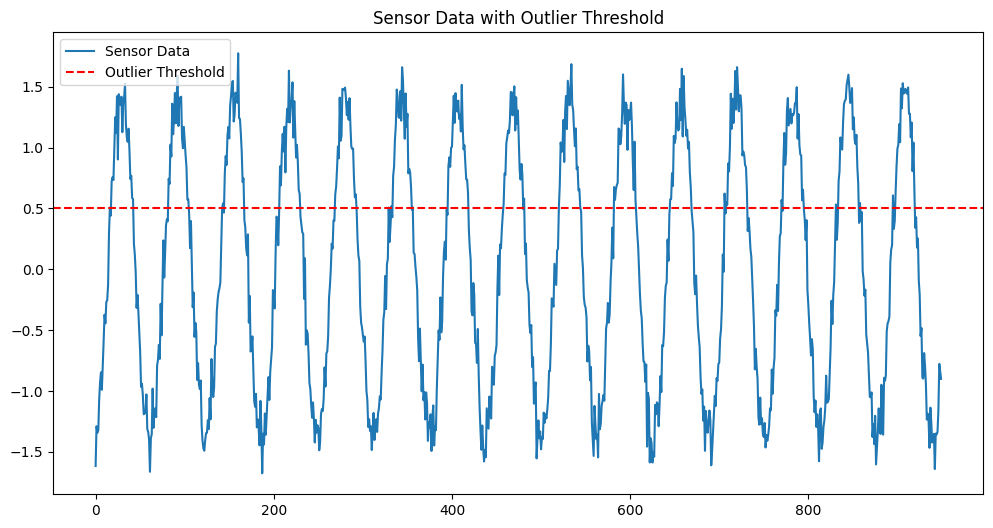

In [29]:
# Anomaly detection visualization
plt.figure(figsize=(12, 6))
plt.plot(X[:, -1, 0], label="Sensor Data")
plt.axhline(y=0.5, color='r', linestyle='--', label="Outlier Threshold")
plt.legend()
plt.title("Sensor Data with Outlier Threshold")
plt.show()

In [30]:
# Model evaluation
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch_X, batch_y in dataloader:
        outputs = torch.sigmoid(model(batch_X)).squeeze()  # Apply sigmoid at inference
        predictions.extend(outputs.numpy())
        actuals.extend(batch_y.numpy())

roc_auc = roc_auc_score(actuals, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(actuals, np.round(predictions), average='binary')
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

ROC-AUC: 0.9964
Precision: 0.9255, Recall: 0.9582, F1-Score: 0.9415


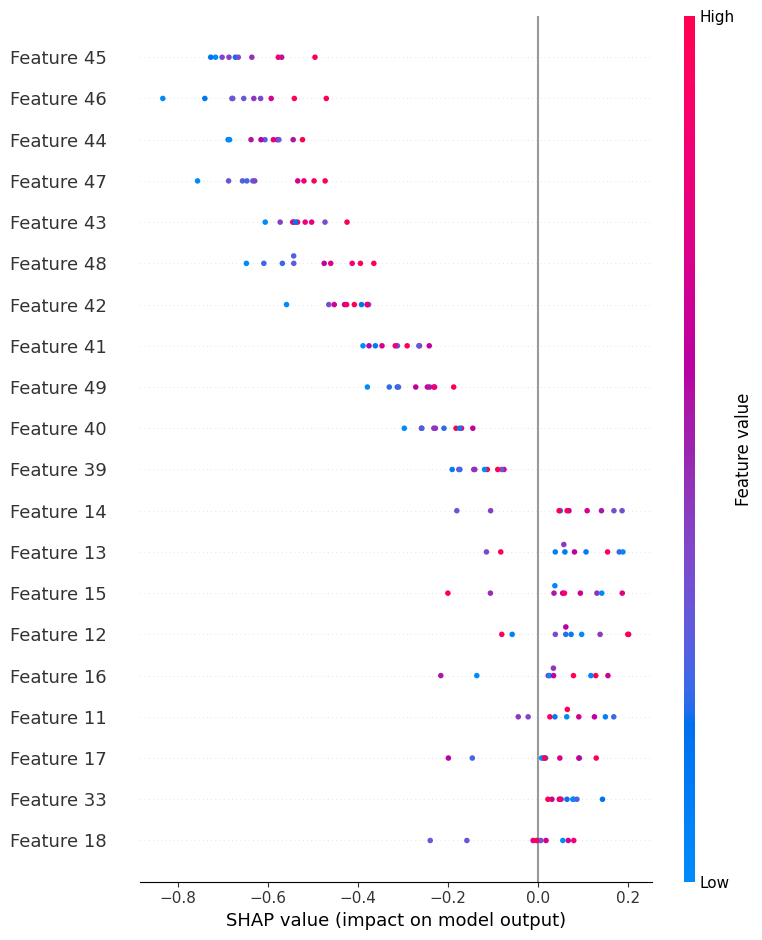

In [35]:
# Feature explainability using SHAP
background = torch_X[:100]
test_samples = torch_X[:10]
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_samples)
shap.summary_plot(shap_values.squeeze(), test_samples.squeeze().numpy())